# Load libraries

### Make sure external libraries are installed

In [190]:
%%sh
pip install biopython pandas seaborn tqdm msprime

### Load what we need

In [148]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
from pathlib import Path

from Bio import Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Phylo.Consensus import *

# Open files

In [75]:
working_dir = Path("/Users/regevschweiger/git/practical/")

In [76]:
aln = AlignIO.read(working_dir / "iqtree-2.2.2.6-example.phy", format="phylip")

# Calculate the distance matrix

In [186]:
def view_distance_matrix(distance_matrix, return_matrix=False):
    n_names = len(distance_matrix)
    D = np.zeros((n_names, n_names))
    for i in range(n_names):
        D[i,:i+1] = distance_matrix.matrix[i]
    names = np.array(distance_matrix.names).astype(str)
    df = pd.DataFrame(data=D, index=names, columns=names)
    
    if return_matrix:
        return df
    
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(df, vmin=0, square=True, ax=ax)
    ax.set_title("Distance matrix")

In [158]:
print(DistanceCalculator.dna_models)

['benner22', 'benner6', 'benner74', 'blastn', 'dayhoff', 'feng', 'genetic', 'gonnet1992', 'hoxd70', 'johnson', 'jones', 'levin', 'mclachlan', 'mdm78', 'megablast', 'blastn', 'rao', 'risler', 'schneider', 'str', 'trans']


In [102]:
# For other DNA model options: print(DistanceCalculator.dna_models)
distance_matrix = DistanceCalculator('identity').get_distance(aln)

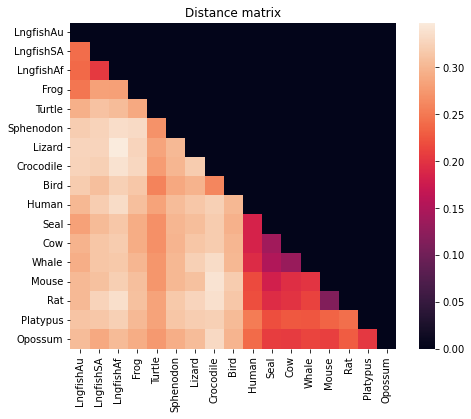

In [105]:
view_distance_matrix(distance_matrix)


# Build a tree

## Neighbor joining

In [111]:
NJ_constructor = DistanceTreeConstructor(DistanceCalculator('identity'), "nj")

In [119]:
NJ_tree = NJ_constructor.build_tree(aln)

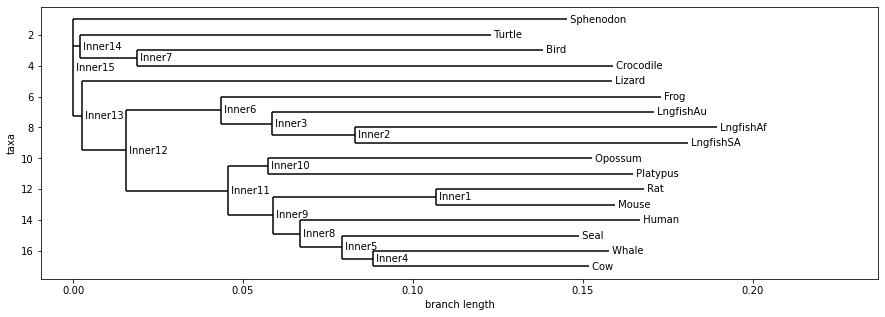

In [125]:
# Possible: NJ_tree.ladderize()
fig, ax = plt.subplots(figsize=(15,5))
Phylo.draw(NJ_tree, axes=ax)

## UPGMA

In [127]:
UPGMA_constructor = DistanceTreeConstructor(DistanceCalculator('identity'), 'upgma')

In [129]:
UPGMA_tree = UPGMA_constructor.build_tree(aln)

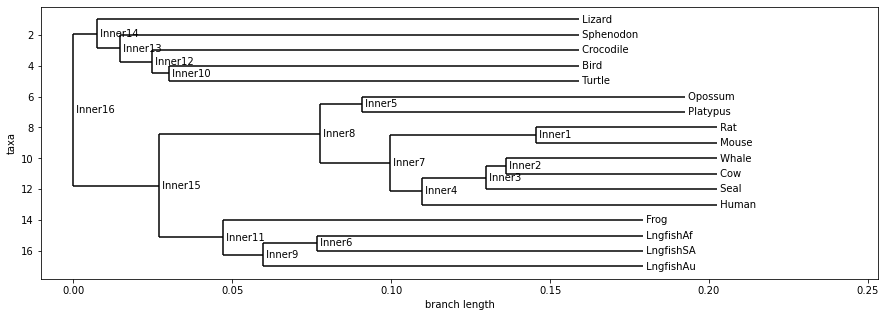

In [130]:
# Possible: NJ_tree.ladderize()
fig, ax = plt.subplots(figsize=(15,5))
Phylo.draw(UPGMA_tree, axes=ax)

# Bootstrapping

In [132]:
bootstrap_alns = list(bootstrap(aln, 10))

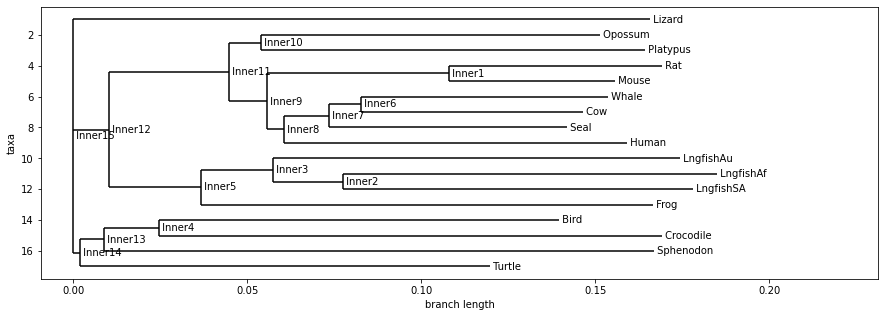

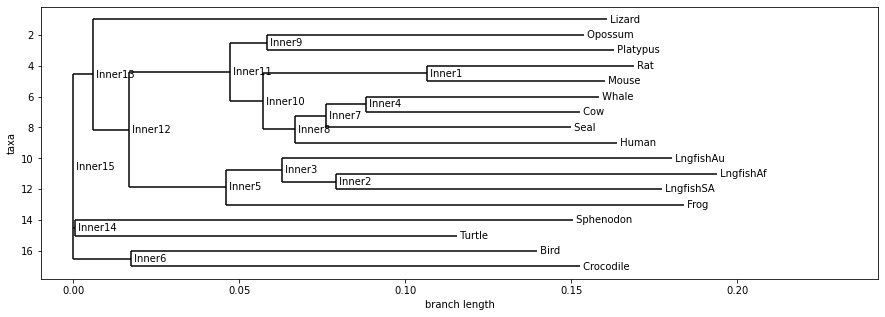

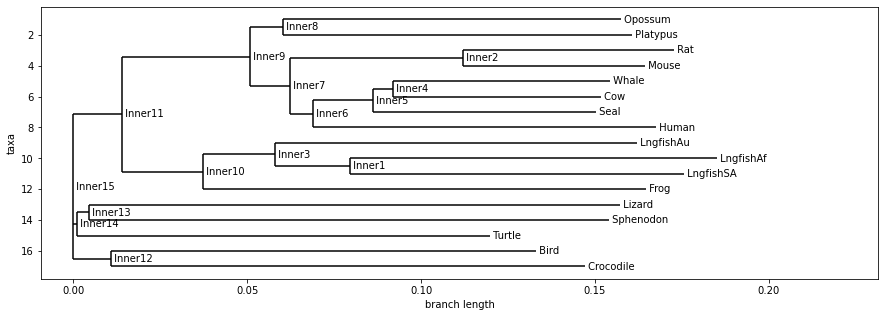

In [161]:
for bootstrap_aln in bootstrap_alns[:3]:
    fig, ax = plt.subplots(figsize=(15,5))
    Phylo.draw(NJ_constructor.build_tree(bootstrap_aln), axes=ax)


### Build on a shorter segment

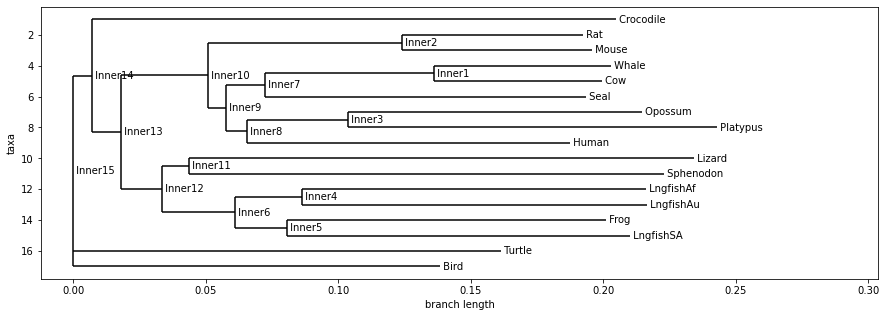

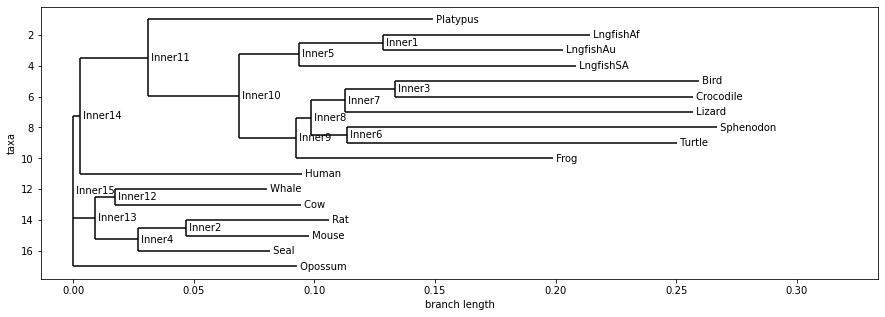

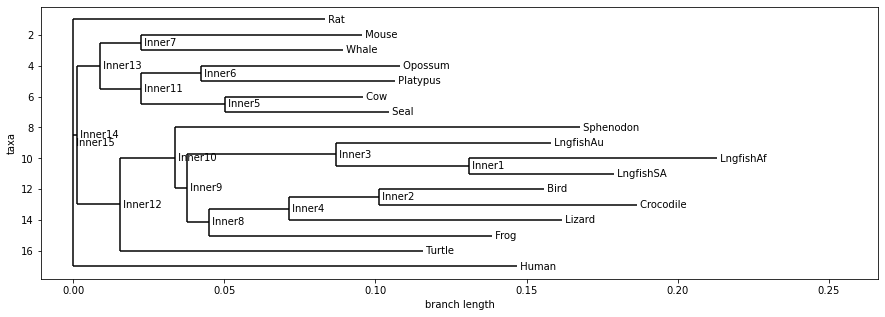

In [162]:
for bootstrap_aln in bootstrap_alns[:3]:
    shorter_aln = bootstrap_aln[:, :100]
    
    fig, ax = plt.subplots(figsize=(15,5))
    Phylo.draw(NJ_constructor.build_tree(shorter_aln), axes=ax)


# Consensus trees and confidence

In [156]:
bootstrap_trees = [UPGMA_constructor.build_tree(bootstrap_aln) for bootstrap_aln in bootstrap(aln, 100)]

In [163]:
maj_tree = majority_consensus(bootstrap_trees)

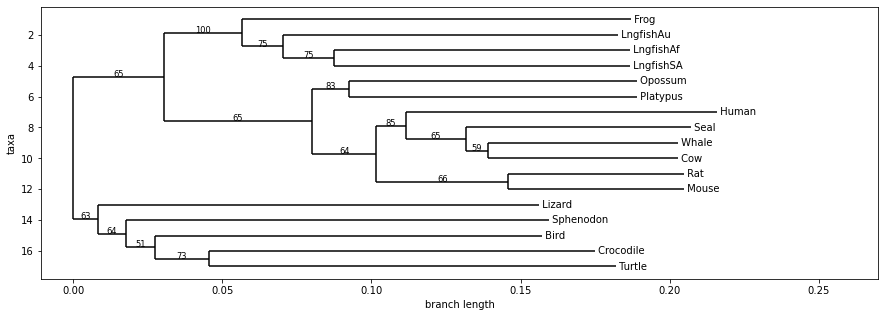

In [164]:
fig, ax = plt.subplots(figsize=(15,5))
Phylo.draw(maj_tree, axes=ax)

# Try globins example

In [167]:
lines = open("/Users/regevschweiger/Downloads/globins.aln").readlines()
with open("./globins.fasta", "w") as F:
    for line in lines[2:]:
        name, seq = line.strip().split(':\t')
        F.write(f">{name}\n")
        F.write(f"{seq}\n")

In [181]:
globins_aln = AlignIO.read(working_dir / "globins.fasta", format="fasta")

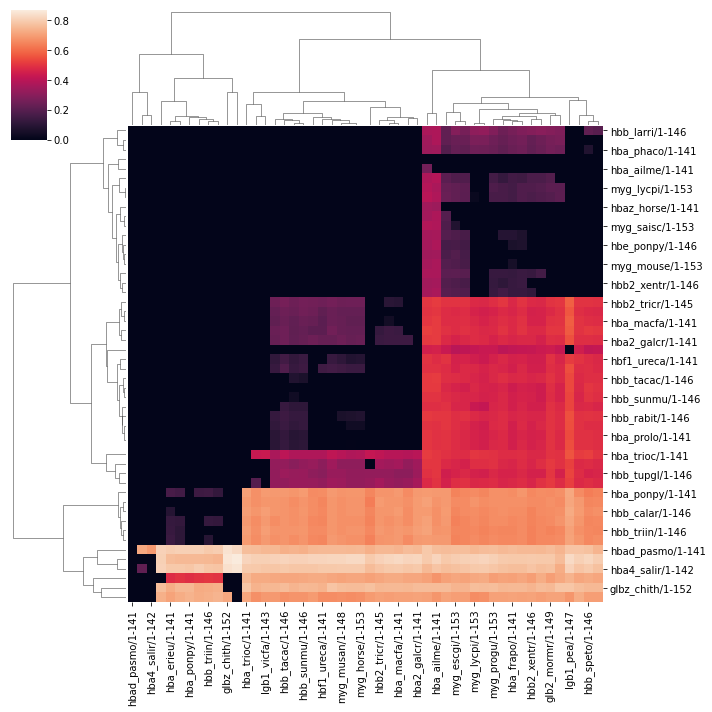

In [188]:
sns.clustermap(
    view_distance_matrix(DistanceCalculator('identity').get_distance(globins_aln), return_matrix=True)
)

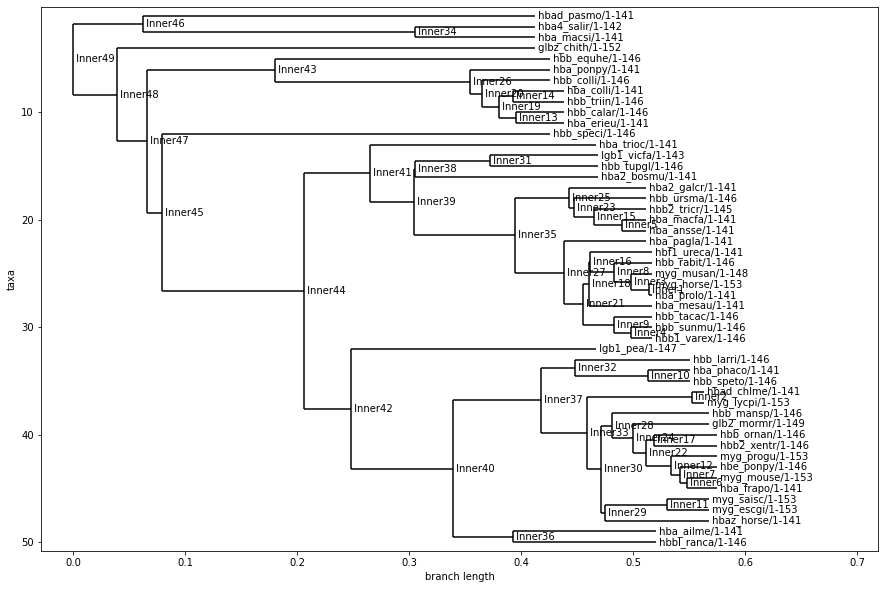

In [183]:
fig, ax = plt.subplots(figsize=(15,10))
Phylo.draw(UPGMA_constructor.build_tree(globins_aln), axes=ax)

In [179]:
uqtree_globins_tree = Phylo.read(working_dir / "globins.fasta.treefile", format="newick")

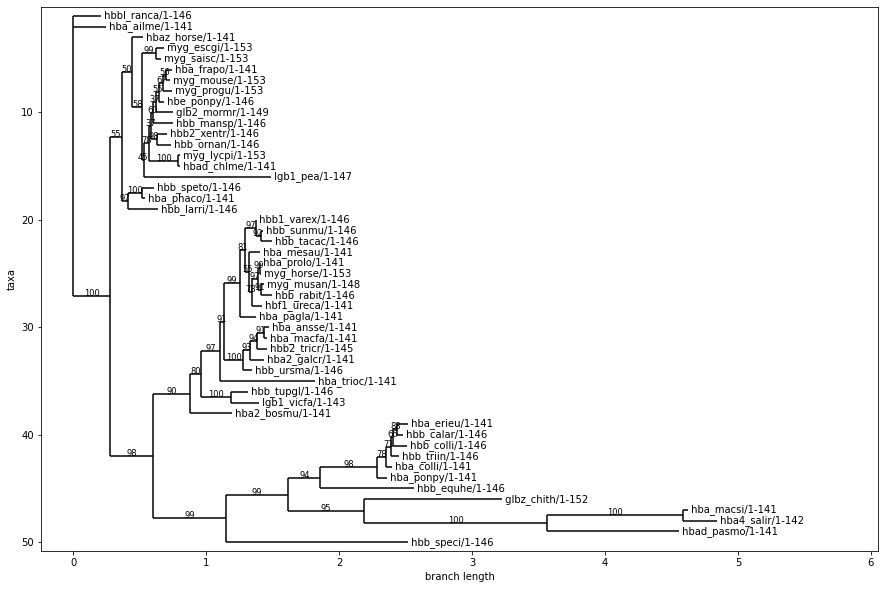

In [180]:
fig, ax = plt.subplots(figsize=(15,10))
Phylo.draw(uqtree_globins_tree, axes=ax)

# Simulate

In [240]:
import msprime, collections, tskit
import tempfile

## Simulate sequences

In [210]:
great_apes_species_tree = "((human:7,chimp:7)HC:3,gorilla:10):HCG"

great_apes_initial_size = collections.defaultdict(lambda: 50000)
great_apes_initial_size.update({
    "human": 20000, 
    "chimp": 50000, 
    "gorilla": 50000,
})

great_apes_demography = msprime.Demography.from_species_tree(
    great_apes_species_tree, 
    great_apes_initial_size,
    time_units="myr",
    generation_time=20,
)

In [214]:
ts = msprime.sim_ancestry(
    samples={"human": 5, "chimp": 5, "gorilla": 5},
    ploidy=1,
    demography=great_apes_demography,
    sequence_length=10000,
    discrete_genome=True,
    recombination_rate=1e-8,    
)

ts = msprime.sim_mutations(
    tree_sequence=ts,
    rate=1e-8,
    model="jc69",
    discrete_genome=True,
)

In [230]:
sim_sequences = list(ts.alignments(reference_sequence=tskit.random_nucleotides(ts.sequence_length)))

## Save as fasta

In [254]:
F = open("./great_apes.fasta", "w")
for i in range(len(sim_sequences)):
    F.write(f">{i}\n{sim_sequences[i]}\n")
    
great_apes_aln = AlignIO.read(F.name, "fasta")


## UPGMA

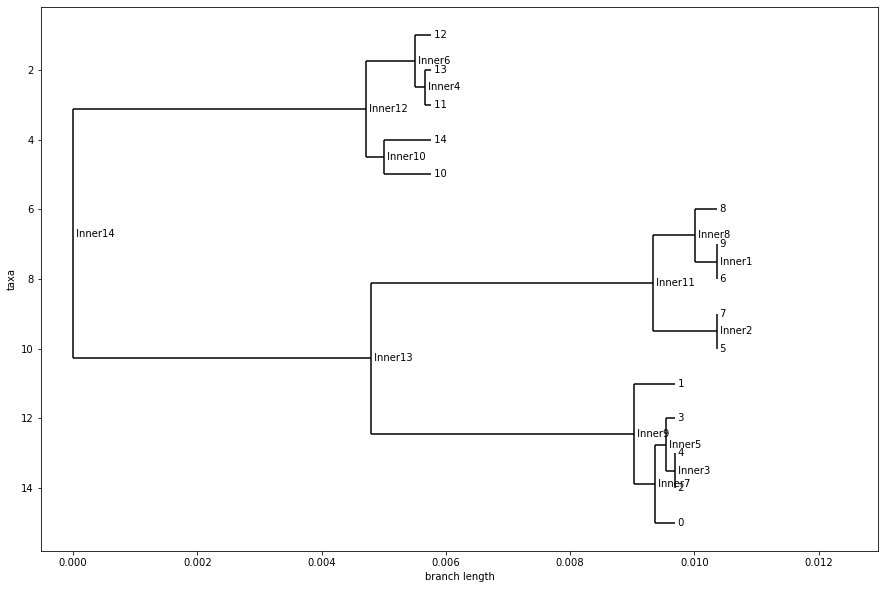

In [253]:
fig, ax = plt.subplots(figsize=(15,10))
Phylo.draw(UPGMA_constructor.build_tree(great_apes_aln), axes=ax)

## Run IQtree

In [258]:
%%sh
~/Downloads/iqtree-2.2.2.6-MacOSX/bin/iqtree2 -s ./great_apes.fasta -B 1000 -nt 4

IQ-TREE multicore version 2.2.2.6 COVID-edition for Mac OS X 64-bit built May 27 2023
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams, Ly Trong Nhan.

Host:    dhcp-10-249-3-46.eduroam.wireless.private.cam.ac.uk (SSE4.2, 16 GB RAM)
Command: /Users/regevschweiger/Downloads/iqtree-2.2.2.6-MacOSX/bin/iqtree2 -s ./great_apes.fasta -B 1000 -nt 4
Seed:    943896 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Tue Feb 13 14:25:09 2024
Kernel:  SSE2 - 4 threads (10 CPU cores detected)

Reading alignment file ./great_apes.fasta ... Fasta format detected
Reading fasta file: done in 0.00688195 secs using 95.35% CPU
Alignment most likely contains DNA/RNA sequences
Constructing alignment: done in 0.00749111 secs using 312.9% CPU
Alignment has 15 sequences with 10000 columns, 100 distinct patterns
174 parsimony-informative, 27 singleton sites, 9799 constant sites
    Gap/Ambiguity  Composition  p-value

133  TIM2+F        15576.860    33  31219.721    31219.946    31457.662
134  TIM2+F+I      15571.604    34  31211.208    31211.447    31456.360
135  TIM2+F+G4     15571.657    34  31211.315    31211.553    31456.466
136  TIM2+F+I+G4   15571.638    35  31213.276    31213.529    31465.638
155  TIM2e         15577.097    30  31214.193    31214.380    31430.504
156  TIM2e+I       15571.837    31  31205.674    31205.873    31429.195
157  TIM2e+G4      15571.888    31  31205.776    31205.975    31429.296
158  TIM2e+I+G4    15571.861    32  31207.722    31207.934    31438.453
177  TIM+F         15577.356    33  31220.712    31220.937    31458.653
178  TIM+F+I       15572.070    34  31212.140    31212.379    31457.292
179  TIM+F+G4      15572.112    34  31212.225    31212.464    31457.376
180  TIM+F+I+G4    15572.095    35  31214.190    31214.443    31466.552
199  TIMe          15577.559    30  31215.118    31215.305    31431.428
200  TIMe+I        15572.270    31  31206.539    31206.738    31

376  TNe+I         15572.285    30  31204.570    31204.756    31420.880
377  TNe+G4        15572.340    30  31204.680    31204.867    31420.990
378  TNe+I+G4      15572.310    31  31206.621    31206.820    31430.141
397  HKY+F         15577.394    31  31216.788    31216.987    31440.308
398  HKY+F+I       15572.107    32  31208.213    31208.425    31438.944
399  HKY+F+G4      15572.164    32  31208.328    31208.540    31439.059
400  HKY+F+I+G4    15572.132    33  31210.264    31210.489    31448.205
419  K2P           15577.593    28  31211.187    31211.350    31413.076
420  K2P+I         15572.303    29  31202.606    31202.780    31411.706
421  K2P+G4        15572.361    29  31202.722    31202.896    31411.821
422  K2P+I+G4      15572.328    30  31204.656    31204.843    31420.967
441  F81+F         15577.455    30  31214.910    31215.097    31431.220
442  F81+F+I       15572.168    31  31206.337    31206.536    31429.857
443  F81+F+G4      15572.226    31  31206.451    31206.650    31

Optimizing NNI: done in 0.00519395 secs using 396.9% CPU
Optimizing NNI: done in 0.0091691 secs using 394.4% CPU
Optimizing NNI: done in 0.00512385 secs using 396% CPU
Iteration 40 / LogL: -15572.354 / Time: 0h:0m:0s (0h:0m:0s left)
Optimizing NNI: done in 0.0053122 secs using 399.4% CPU
Optimizing NNI: done in 0.00525403 secs using 396% CPU
Optimizing NNI: done in 0.00560117 secs using 390.5% CPU
Optimizing NNI: done in 0.00686789 secs using 378.9% CPU
Optimizing NNI: done in 0.00691915 secs using 389.9% CPU
Optimizing NNI: done in 0.00700521 secs using 376.4% CPU
Optimizing NNI: done in 0.00626397 secs using 394.5% CPU
Optimizing NNI: done in 0.00744295 secs using 387.6% CPU
Optimizing NNI: done in 0.00618887 secs using 391.9% CPU
Optimizing NNI: done in 0.00647688 secs using 383.6% CPU
Iteration 50 / LogL: -15572.365 / Time: 0h:0m:0s (0h:0m:0s left)
Log-likelihood cutoff on original alignment: -15609.783
Optimizing NNI: done in 0.0066781 secs using 393.8% CPU
Optimizing NNI: done in

## Open IQtree outputs

### ML

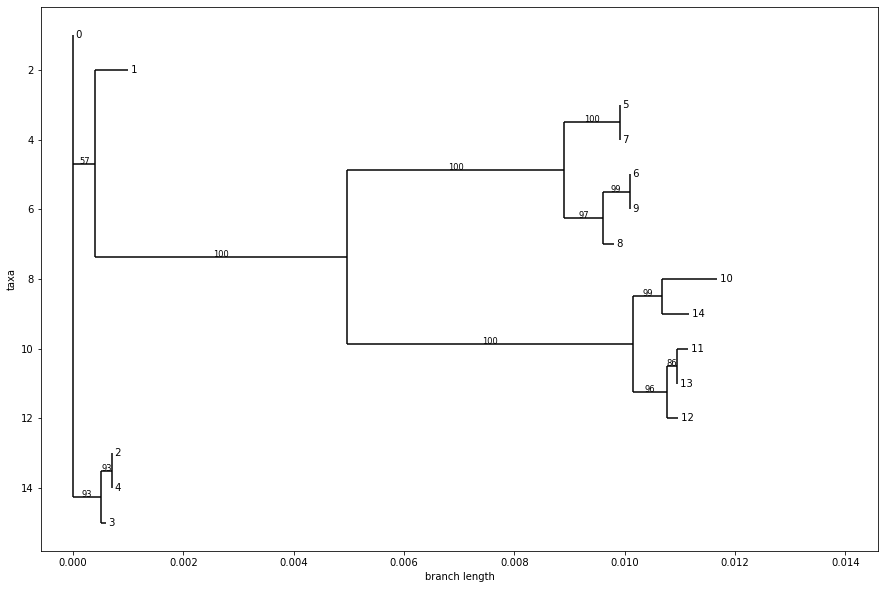

In [261]:
fig, ax = plt.subplots(figsize=(15,10))
Phylo.draw(Phylo.read("./great_apes.fasta.treefile", "newick"), axes=ax)

### See ML distances

In [270]:
mat = np.array([line.strip().split()[1:] for line in open("./great_apes.fasta.mldist").readlines()[1:]]).astype(float)
    

<AxesSubplot:>

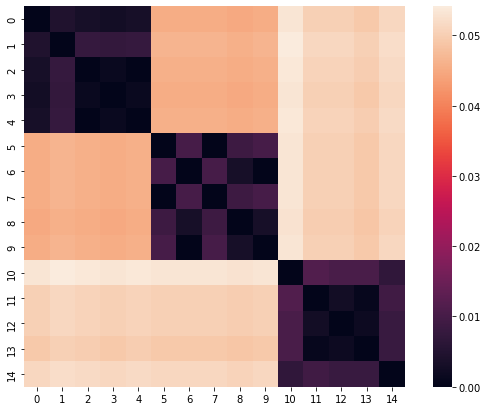

In [276]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(
    mat, 
    square=True, 
    ax=ax,
)